In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sklearn.neighbors
import desc.pserv
import desc.pserv.utils as pserv_utils

In [2]:
import treecorr as tc

In [3]:
import glob

In [4]:
import healpy as hp

In [5]:
import time

In [6]:
import astropy.table

In [7]:
from multiprocessing import Pool

In [8]:
from scipy.stats import binned_statistic

In [9]:
import lsst.daf.persistence
DATA_DIR_DITHERED = "/global/cscratch1/sd/descdm/DC1/DC1-imsim-dithered/"
DATA_DIR_UNDITHERED = "/global/cscratch1/sd/descdm/DC1/DC1-imsim-undithered/"
DATA_DIR_PHOSIM ="/global/cscratch1/sd/descdm/DC1/DC1-phoSim-3a/"

In [10]:
table_name = 'StarTruth'
#projectId = 0
#projectName = 'DC1 imsim undithered'
projectId = 1
projectName = 'DC1 imsim dithered'

conn = desc.pserv.DbConnection(host='nerscdb04.nersc.gov',
                               port=3306,
                               database='DESC_DC1_Level_2')

In [11]:
star_truth = conn.get_pandas_data_frame('select * from StarTruth')
tree = sklearn.neighbors.KDTree(
    np.array(((star_truth['raICRS'].values*np.pi/180.,
               star_truth['decICRS'].values*np.pi/180.))).transpose())

query = '''select id, coord_ra, coord_dec,
           base_PsfFlux_flux, base_PsfFlux_fluxSigma
           from Coadd_Object where deblend_nChild=0
           and base_ClassificationExtendedness_value=0
           and projectId=%i limit 100000''' % projectId
query_u = '''select id, coord_ra, coord_dec,
           base_PsfFlux_flux, base_PsfFlux_fluxSigma
           from Coadd_Object where deblend_nChild=0
           and base_ClassificationExtendedness_value=0
           and projectId=%i limit 100000''' % 0
tstart = time.time()
imsim_stars = conn.get_pandas_data_frame(query)
imsim_stars_u = conn.get_pandas_data_frame(query_u)
print('query time:', time.time() - tstart)
candidates = np.array(((imsim_stars['coord_ra'].values,
                        imsim_stars['coord_dec'].values))).transpose()


('query time:', 405.14625811576843)


In [12]:
candidates_u = np.array(((imsim_stars_u['coord_ra'].values,
                        imsim_stars_u['coord_dec'].values))).transpose()

In [13]:
offset, index = tree.query(candidates, k=1)

In [14]:
offset_u, index_u = tree.query(candidates_u, k=1)

In [15]:
x0 = star_truth['raICRS'].values[index][::50].flatten()
y0 = star_truth['decICRS'].values[index][::50].flatten()
dx = star_truth['raICRS'].values[index][::50].flatten()-imsim_stars['coord_ra'].values[::50].flatten()*180/np.pi
dy = star_truth['decICRS'].values[index][::50].flatten()-imsim_stars['coord_dec'].values[::50].flatten()*180/np.pi

In [16]:
x0_u = star_truth['raICRS'].values[index_u][::50].flatten()
y0_u = star_truth['decICRS'].values[index_u][::50].flatten()
dx_u = star_truth['raICRS'].values[index_u][::50].flatten()-imsim_stars_u['coord_ra'].values[::50].flatten()*180/np.pi
dy_u = star_truth['decICRS'].values[index_u][::50].flatten()-imsim_stars_u['coord_dec'].values[::50].flatten()*180/np.pi

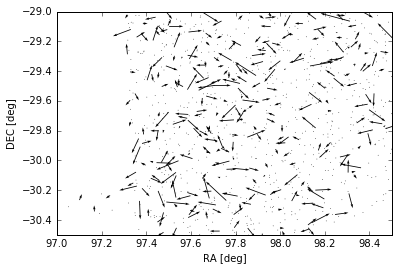

In [17]:
# We are going to multiply the arrows times 20 to be able to see them
plt.quiver(x0,y0,dx,dy, scale_units='xy', angles='xy', scale=0.05)
plt.xlim(97.0,98.5)
plt.ylim(-30.5,-29.0)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

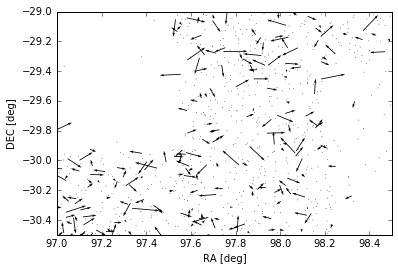

In [18]:
plt.quiver(x0_u,y0_u,dx_u,dy_u, scale_units='xy', angles='xy', scale=0.05)
plt.xlim(97.0,98.5)
plt.ylim(-30.5,-29.0)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

I am going to check the power spectrum of the displacements to see how it looks like

In [39]:
cat = tc.Catalog(ra=x0_u, dec=y0_u, g1=dx_u, g2=dy_u, ra_units='deg', dec_units='deg')
cat2 = tc.Catalog(ra=x0, dec=y0, g1=dx, g2=dy, ra_units='deg', dec_units='deg')

In [47]:
gg = tc.GGCorrelation(bin_size=0.1, min_sep=1, max_sep=900, 
                            sep_units='arcmin', bin_slop=0.5)

In [48]:
gg.process(cat,cat)

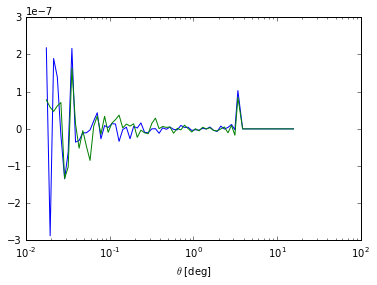

In [50]:
plt.plot(gg.meanr/60,gg.xip,label=r'$\xi_{+}$')
plt.plot(gg.meanr/60,gg.xim,label=r'$\xi_{-}$')
plt.xscale('log')
plt.xlabel(r'$\theta$ [deg]')

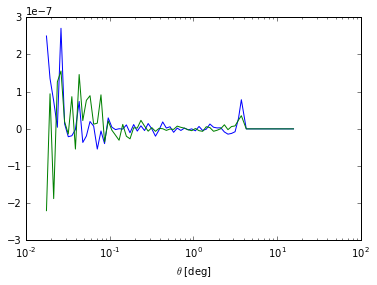

In [52]:
gg_d = tc.GGCorrelation(bin_size=0.1, min_sep=1, max_sep=900, 
                            sep_units='arcmin', bin_slop=0.5)
gg_d.process(cat2,cat2)
plt.plot(gg_d.meanr/60,gg_d.xip,label=r'$\xi_{+}$')
plt.plot(gg_d.meanr/60,gg_d.xim,label=r'$\xi_{-}$')
plt.xscale('log')
plt.xlabel(r'$\theta$ [deg]')

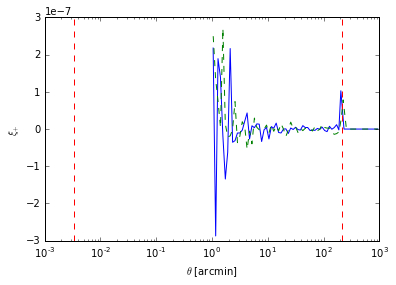

In [66]:
plt.plot(gg.meanr,gg.xip,label=r'$\xi_{u,+}$')
#plt.plot(gg.meanr,gg.xim,label=r'$\xi_{u,-}$')
plt.plot(gg_d.meanr,gg_d.xip,'--',label=r'$\xi_{d,+}$')
plt.plot(3.5*60*np.ones(3),np.linspace(-3e-7,3e-7,3),'r--')
plt.plot(0.2/60*np.ones(3),np.linspace(-3e-7,3e-7,3),'r--')
#plt.plot(gg_d.meanr,gg_d.xim,'--',label=r'$\xi_{d,-}$')
plt.xscale('log')
plt.ylabel(r'$\xi_{+}$')
plt.xlabel(r'$\theta$ [arcmin]')

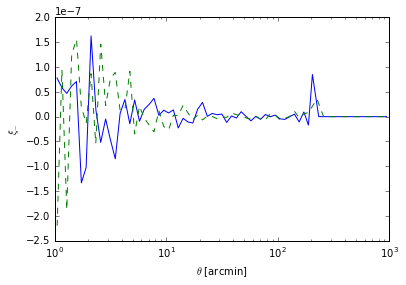

In [64]:
plt.plot(gg.meanr,gg.xim,label=r'$\xi_{u,-}$')
plt.plot(gg_d.meanr,gg_d.xim,'--',label=r'$\xi_{d,-}$')
plt.xscale('log')
plt.ylabel(r'$\xi_{-}$')
plt.xlabel(r'$\theta$ [arcmin]')

In [19]:
ccd_visit = conn.get_pandas_data_frame('select * from CcdVisit')

In [20]:
ccd_visit.keys()

Index([u'ccdVisitId', u'visitId', u'ccdName', u'raftName', u'filterName',
       u'nExposures', u'ra', u'decl', u'zenithDistance', u'llcx', u'llcy',
       u'ulcx', u'ulcy', u'urcx', u'urcy', u'lrcx', u'lrcy', u'xSize',
       u'ySize', u'obsStart', u'expMidpt', u'expTime', u'darkTime', u'ccdTemp',
       u'binX', u'binY', u'WCS', u'zeroPoint', u'seeing', u'skyBg',
       u'skyNoise', u'flags', u'projectId'],
      dtype='object')

/global/common/cori/contrib/lsst/lsstDM/v13_0/Linux64/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/global/common/cori/contrib/lsst/lsstDM/v13_0/Linux64/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


1187.01491115


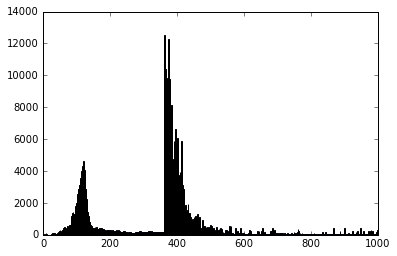

In [21]:
plt.hist(ccd_visit['skyBg'],range=(0,1000),bins=500);
print np.nanmean(ccd_visit['skyBg'])

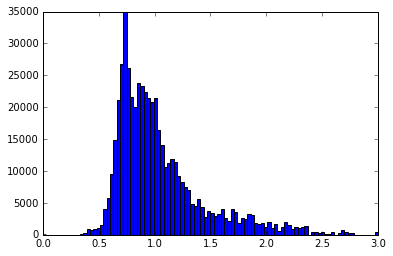

In [22]:
plt.hist(ccd_visit['seeing'],range=(0,3),bins=100);

In [23]:
butler = lsst.daf.persistence.Butler(DATA_DIR_DITHERED)
butler_u = lsst.daf.persistence.Butler(DATA_DIR_UNDITHERED)
butler_p = lsst.daf.persistence.Butler(DATA_DIR_PHOSIM)

In [24]:
print butler.getKeys("calexp")

{'filter': <type 'str'>, 'raft': <type 'str'>, 'sensor': <type 'str'>, 'visit': <type 'int'>}


In [25]:
dithered_visits = ccd_visit['projectId'].values==1

In [26]:
undithered_visits = ccd_visit['projectId'].values==0

In [27]:
phosim_visits = ccd_visit['projectId'].values==2

In [28]:
print np.count_nonzero(dithered_visits), np.count_nonzero(undithered_visits), np.count_nonzero(phosim_visits)

184658 152523 189354


In [29]:
def get_ra_dec(entry_num,visit_table=ccd_visit[phosim_visits],b=butler_p):
    i=entry_num
    if i%1000==0:
        print i
    visitId = {'filter':visit_table['filterName'].values[i], 'raft':visit_table['raftName'].values[i],
               'sensor':visit_table['ccdName'].values[i], 'visit':visit_table['visitId'].values[i]}
    try:
        calexp = b.get("calexp",visitId,immediate=True)
        ra=calexp.getWcs().getSkyOrigin().toIcrs().getRa().asDegrees()
        dec=calexp.getWcs().getSkyOrigin().toIcrs().getDec().asDegrees()
    except:
        ra=np.nan
        dec=np.nan
    return ra,dec

In [30]:
%time get_ra_dec(10)

CPU times: user 72 ms, sys: 104 ms, total: 176 ms
Wall time: 262 ms


(93.94361506134948, -32.391986143984596)

In [31]:
p = Pool(4)
ra_dec_array_p = p.map(get_ra_dec, [i for i in range(40000)])

5000
0
3000
8000
1000
6000
4000
9000
2000
7000
10000
15000
13000
18000
11000
16000
14000
19000
12000
17000
20000
25000
23000
28000
21000
26000
24000
29000
22000
27000
30000
35000
33000
38000
31000
36000
34000
39000
32000
37000


In [33]:
ra_dec_array_p = np.array(ra_dec_array_p)

In [34]:
len(ra_dec_array_p[:,0][~np.isnan(ra_dec_array_p[:,0])])

39927

In [36]:
tab = astropy.table.Table([ra_dec_array_p[:,0],ra_dec_array_p[:,1]],names=('ra [deg]', 'dec [deg]'))
tab.write('phosim_pointings_ra_dec_40k.fits.gz', overwrite=True)

In [37]:
def make_hp_metric(visit_table,var,coord_array,metric='mean',nside=4096):
    good = np.logical_not(np.isnan(coord_array[:,0]))
    pix_nums = hp.ang2pix(nside,np.pi/2.-coord_array[:,1][good]*np.pi/180,coord_array[:,0][good]*np.pi/180)
    pix_counts = np.bincount(pix_nums,minlength=12*nside**2)
    pix_weight = np.bincount(pix_nums,weights=visit_table[var].values[good],minlength=12*nside**2)
    pix_weight2 = np.bincount(pix_nums,weights=visit_table[var].values[good]**2,minlength=12*nside**2)
    if metric=='mean':
        map_out = np.zeros_like(pix_counts)
        map_out[pix_counts!=0] = pix_weight[pix_counts!=0]/pix_counts[pix_counts!=0]
        return map_out
    if metric=='rms':
        map_out = np.zeros_like(pix_counts)
        map_out[pix_counts!=0] = np.sqrt(pix_weight2[pix_counts!=0]/pix_counts[pix_counts!=0] \
                                         -(pix_weight[pix_counts!=0]/pix_counts[pix_counts!=0])**2)
        return map_out
    if metric=='median':
        map_out, _ , _ = binned_statistic(pix_nums,visit_table[var].values[good],bins=12*nside**2,statistic=metric,range=(0,12*nside**2))
        return map_out
    else:
        print 'Only mean and rms defined!'

In [ ]:
map_seeing = make_hp_metric(ccd_visit[undithered_visits],'seeing',ra_dec_array_u,nside=2048)
map_seeing_rms = make_hp_metric(ccd_visit[undithered_visits],'seeing',ra_dec_array_u,metric='rms',nside=2048)
map_seeing_median = make_hp_metric(ccd_visit[undithered_visits],'seeing',ra_dec_array_u,metric='median',nside=2048)

In [ ]:
hp.gnomview(map_seeing, rot=(94, -28), reso=4, title='Mean seeing', max=1.5, min=0.4)

In [ ]:
hp.gnomview(map_seeing_rms, rot=(94, -28), reso=4, title='RMS seeing')

In [ ]:
hp.gnomview(map_seeing_median, rot=(94, -28), reso=4, title='Median seeing', max=1.5, unit='arcsec')

In [ ]:
map_bg = make_hp_metric(ccd_visit[undithered_visits],'skyBg',ra_dec_array_u,nside=2048)
map_bg_rms = make_hp_metric(ccd_visit[undithered_visits],'skyBg',ra_dec_array_u,metric='rms',nside=2048)
map_gb_median = make_hp_metric(ccd_visit[undithered_visits],'skyBg',ra_dec_array_u,metric='median',nside=2048)

In [ ]:
hp.gnomview(map_bg, rot=(94, -28), reso=4, title='Mean background',max=800, min=0)

In [ ]:
hp.gnomview(map_gb_median, rot=(94, -28), reso=4, title='Median background',max=800, min=0,unit='ADU')